In [1]:
# First, we can import some functions so we can use the model
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
import matplotlib.pyplot as plt
from cobra.flux_analysis import production_envelope

In [2]:
# Second, we can read the GEM and save it as ‘model’
model = read_sbml_model('data/iML1515_het.xml')

    · ENZYME 1: Reaction ACACT1r is already present in E.coli. Enzyme EC 2.3.1.9 - acetyl-CoA C-acetyltransferase catalyses the Claisen condensation of an acetyl-CoA and an acyl-CoA (often another acetyl-CoA), leading to the formation of an acyl-CoA. Km = 0.14 mM; Turnover number = 6.5 1/s per mg of protein.

    · ENZYME 2: EC 1.1.1.36 - acetoacetyl-CoA reductase (HACD1) coming from Zoogloea Ramigera and catalyzes the chiral reduction of acetoacetyl-CoA to (R)-3-hydroxybutyryl-CoA. Km = 0.002 mM; Turnover number = 90 1/s per mg of protein.

    · ENZYME 3: EC 2.3.1.304 - poly-(R)-3-hydroxyalkanoate polymerase (phaC) coming from Cupriavidus necator which polymerizes (R)-3-hydroxybutyryl-CoA to create polyhydroxybutyrate (PHB). Km = 0.32 mM; Turnover number = 44 1/s per mg of protein.

Because we cannot use OptGene to determine which genes to overexpress and thus increase P3HB production, we decided to base the overexpression assay based on the properties of the enzymes. In the sublot of production enzymes, the overexpressed gene is the one corresponding to the ACACT1r reaction.

The bottleneck in a metabolic pathway is typically determined by the slowest step, which is often associated with the enzyme that has the lowest turnover number. The turnover number, also known as kcat (catalytic constant), represents the number of substrate molecules converted to product per unit time by a single enzyme molecule.

The turnover number for Enzyme 1 is significantly lower than the turnover numbers for other two enzymes. This means that Enzyme 1 processes substrate molecules at a slower rate compared to the other enzymes in the pathway. As a result, Enzyme 1 becomes the bottleneck because it limits the overall rate of the pathway. Therefore is the main objective for this sublot.

FROM A BIOLOGICAL POINT OF VIEW.

In [14]:
solution = model.optimize()
growth_reduction_values = []
overexpression_factor_values = []
#Now that we have set which will be the max biomass reachable...
with model:
    #Set bounds of biomass inside with model, therefore can be changed for simulation
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.8 * solution.objective_value
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound = solution.objective_value
    #Max value will always be the optimal value reachable
    
    #Now we set the set of reactions that lead to P3HB production
#     reaction_ACACT1r_aacoa_c = model.add_boundary(model.metabolites.get_by_id("aacoa_c"))
#     reaction_HACD1_hbtcoa_c = model.add_boundary(model.metabolites.get_by_id("3hbcoa_c"))
    reaction_phaC_P3HB_c = model.add_boundary(model.metabolites.get_by_id("P3HB_c"), type="sink")
    
    #Before setting the new objective we have to look to basal fluxes of this reactions
    flux_summary1 = model.metabolites.aacoa_c.summary()
    flux_summary2 = model.metabolites.get_by_id("3hbcoa_c").summary()
    flux_summary3 = model.metabolites.P3HB_c.summary()
    print(f"ACACT1r (aacoa_c) flux before setting objective: {round(flux_summary1.to_frame().loc['ACACT1r', 'flux'],4)}")
    print(f"HACD1 (3hbcoa_c) flux before setting objective: {round(flux_summary2.to_frame().loc['HACD1', 'flux'],4)}")
    print(f"phaC (P3HB_c) flux before setting objective: {round(flux_summary3.to_frame().loc['phaC', 'flux'],4)}")
    
    growth = solution.objective_value
    for i in range(1, 11):
        growth = solution.objective_value
        aacoa_c_flux = solution.fluxes["ACACT1r"]
        model.reactions.ACACT1r.lower_bound = aacoa_c_flux * i
        solution_overexpression = model.optimize()
        growth_overexpression = solution_overexpression.objective_value

        growth_reduction = growth - growth_overexpression 
        
        growth_reduction_values.append(growth_reduction)
        overexpression_factor_values.append(i)
        
    print(f"\nBasal optimal growth: {round(growth,4)}")
    print(f"Growth reduction is: {round(growth_reduction,4)}")


ACACT1r (aacoa_c) flux before setting objective: 0.3121
HACD1 (3hbcoa_c) flux before setting objective: 0.3121
phaC (P3HB_c) flux before setting objective: 0.0

Basal optimal growth: 0.877
Growth reduction is: 0.181


C:\Users\vfier\anaconda3\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


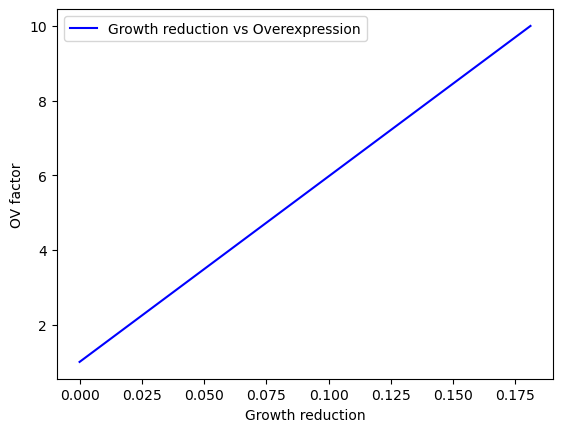

In [4]:
plt.plot(growth_reduction_values, overexpression_factor_values, color='blue', linestyle='-', marker='', markersize=2, label='Growth reduction vs Overexpression')

# Add labels and title
plt.xlabel('Growth reduction')
plt.ylabel('OV factor')

# Show the plot
plt.legend()
plt.show()

In [20]:
solution = model.optimize()
growth_reduction_values = []
overexpression_factor_values = []
#Now that we have set which will be the max biomass reachable...
with model:
    #Set bounds of biomass inside with model, therefore can be changed for simulation
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.8 * solution.objective_value
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound = solution.objective_value
    #Max value will always be the optimal value reachable
    
    #Now we set the set of reactions that lead to acetate uptake
#     reaction_ACKr_actp_c = model.add_boundary(model.metabolites.get_by_id("actp_c"))
#     reaction_PTAr_hbtcoa_c = model.add_boundary(model.metabolites.get_by_id("accoa_c"))
    
    #Before setting the new objective we have to look to basal fluxes of this reactions
    flux_summary1 = model.metabolites.actp_c.summary()
    flux_summary2 = model.metabolites.accoa_c.summary()
    
    print(f"ACKr (actp_c) flux before setting objective: {round(flux_summary1.to_frame().loc['ACKr', 'flux'],4)}")
    print(f"PTAr (accoa_c) flux before setting objective: {round(flux_summary2.to_frame().loc['PTAr', 'flux'],4)}")
    
    growth = solution.objective_value
#     for i in range(1, 11):
    growth = solution.objective_value
    actp_c_flux = solution.fluxes["ACKr"]
    model.reactions.ACKr.lower_bound = actp_c_flux * 0
    solution_overexpression = model.optimize()
    growth_overexpression = solution_overexpression.objective_value

    growth_reduction = growth - growth_overexpression 
        
    growth_reduction_values.append(growth_reduction)
    overexpression_factor_values.append(i)
        
    print(f"\nBasal optimal growth: {round(growth,4)}")
    print(f"Growth reduction is: {round(growth_reduction,4)}")
    
    print(round(solution_overexpression["HACD1"],4))

ACKr (actp_c) flux before setting objective: 0.5106
PTAr (accoa_c) flux before setting objective: 0.5106

Basal optimal growth: 0.877
Growth reduction is: -0.0
0.3121


In [26]:
solution = model.optimize()
growth_reduction_values = []
overexpression_factor_values = []
#Now that we have set which will be the max biomass reachable...
with model:
    #Set bounds of biomass inside with model, therefore can be changed for simulation
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.8 * solution.objective_value
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound = solution.objective_value
    #Max value will always be the optimal value reachable
    
    #Now we set the set of reactions that lead to acetate uptake
#     reaction_ACKr_actp_c = model.add_boundary(model.metabolites.get_by_id("actp_c"))
#     reaction_PTAr_hbtcoa_c = model.add_boundary(model.metabolites.get_by_id("accoa_c"))
    
    #Before setting the new objective we have to look to basal fluxes of this reactions
    flux_summary1 = model.metabolites.actp_c.summary()
    flux_summary2 = model.metabolites.accoa_c.summary()
    
    print(f"ACKr (actp_c) flux before setting objective: {round(flux_summary1.to_frame().loc['ACKr', 'flux'],4)}")
    print(f"PTAr (accoa_c) flux before setting objective: {round(flux_summary2.to_frame().loc['PTAr', 'flux'],4)}")
    
    growth = solution.objective_value
#     for i in range(1, 11):
    growth = solution.objective_value
    accoa_c_flux = solution.fluxes["PTAr"]
    model.reactions.PTAr.lower_bound = accoa_c_flux * 1
    
    solution_overexpression = model.optimize()
    growth_overexpression = solution_overexpression.objective_value

    growth_reduction = growth - growth_overexpression 
        
    growth_reduction_values.append(growth_reduction)
    overexpression_factor_values.append(i)
        
    print(f"\nBasal optimal growth: {round(growth,4)}")
    print(f"Growth reduction is: {round(growth_reduction,4)}")
    
    print(round(solution_overexpression["HACD1"],4))

ACKr (actp_c) flux before setting objective: 0.5106
PTAr (accoa_c) flux before setting objective: 0.5106

Basal optimal growth: 0.877
Growth reduction is: 0.0
0.3121
